## 02 - part b - Image Enhancement using histograms

(Moacir A. Ponti, ICMC/USP, 2019)

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import random

Instead of performing image enhancement with arbitrary transformations of each pixel value (in which the value is the only input of the transformation), it is possible to design transformations by using the image information. A widely employed technique in that sense is the histogram-based enhancement, that uses the image *histogram* as a source of information about the intensity distribution over the image.

The histogram is computed by counting how many times each intensity level appears in the image.

In [2]:
# np.random.randint allows creating arrays using integer
# random numbers. 
# OBS: random.randint() can be used to produce a single random int value.
# Below, a matrix 5x5 containing random values between 0 and 7
A = np.random.randint(0,8,[5,5])
print(A)

[[5 2 3 1 1]
 [2 7 6 2 4]
 [2 7 4 3 6]
 [0 7 2 1 1]
 [0 1 7 4 3]]


A fairly simple way to compute the histogram (although there are more optimized ways to do that), is to loop through all intensity/graylevel values, and check how many pixels in the matrix has each value.

Note that this is faster than looping through all pixels of the image.

In [3]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # the np.where() function returns the indices for all coordinates 
        # in some array matching the condition. In this case, all pixels
        # that have value 'i'
        pixels_value_i = np.where(A == i)
        
        #print(pixels_value_i)  # uncomment to print array of coordinates
        
        # by counting how many coordinates the np.where function returned, 
        # we can assign it at the respective histogram bin
        # this is done by getting the size of the vector of coordinates
        hist[i] = pixels_value_i[0].shape[0]
            
    return(hist)

To understand how the `np.where()` function works, you may uncomment the line that prints it in the loop of the function. Note it is an array of multiple arrays.

Let us use the `histogram()` function, passing the random matrix as argument and the number of levels in the matrix. It returns the histogram as an array.

In [4]:
hist_A = histogram(A, 8)
print(hist_A)

[2 5 5 3 3 1 2 4]


The histogram is usually shown using a bar plot. We are going to use `plt.bar()`, that gets as input the range of values in the histogram, and their counting, as follows:

Text(0, 0.5, 'Frequency')

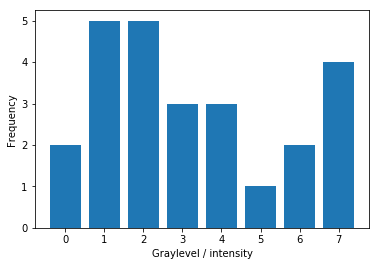

In [5]:
plt.bar(range(8), hist_A)
plt.xlabel('Graylevel / intensity')
plt.ylabel('Frequency')

Let us apply this function to compute the histogram of two real images, and show their plots. Note how the graylevels are distributed according to the different brightness and contrast characteristics of each image.

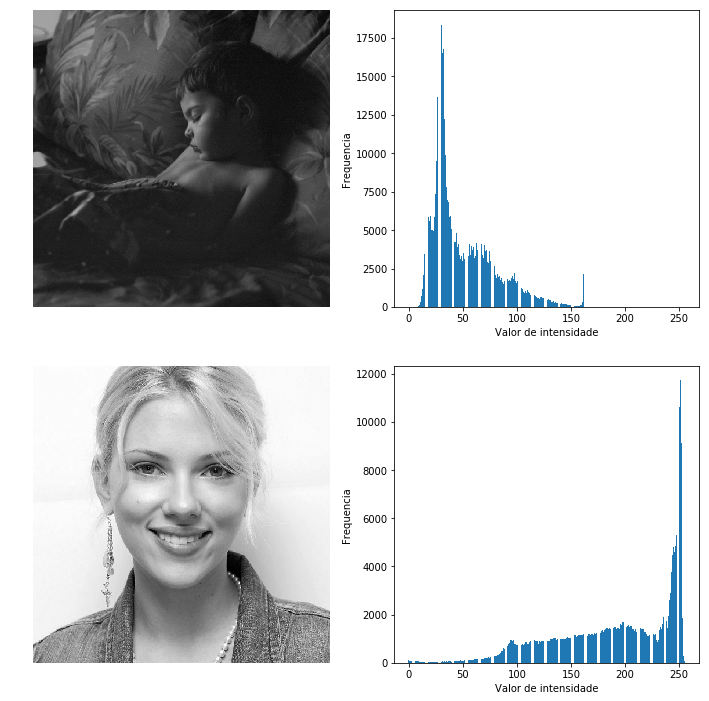

In [8]:
img1 = imageio.imread("images/nap.jpg")
img2 = imageio.imread("images/scarlett.jpg")

# computing histograms considering 256 graylevels
hist_img1 = histogram(img1, 256)
hist_img2 = histogram(img2, 256)

# showing images and their respective histograms
# note that the vmin and vmax parameters are used to show the images
# those are set to ensure the image is going to be shown using all 256
# graylevels, not normalizing it in the visualization
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(223)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(222)
plt.bar(range(256), hist_img1)
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')

plt.subplot(224)
plt.bar(range(256), hist_img2)
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')
plt.show()

Note that the first image, *Nap*, is dominated by dark pixels, while the second image, *Scarlett* is brighter in general, therefore having a concentration of higher graylevels. 
The histogram therefore offers important information about the image.

*We can use this information to design a transformation that is tailored for each image data*

The main method is known as **Histogram Equalisation**.

It uses the cumulative histogram as a function to transform the pixel values and enhance the image. The basic technique for equalisation is designed so that to distribute as uniform as possible the pixels along all range of possible grayvalues.

After computing the cumulative histogram, in order to make it a proper transformation function, we have to scale it (as done with the log transformation, for example) to allow an output in the intervalo 0-255.

The transformation, for each pixel *r* is given by: $$s = T(r) = \frac{L-1}{MN} hc(r)$$ where *hc* is the cumulative histogram and *hc(r)* is the value of the cumulative histogram evaluated at the intensity level *r*

In [12]:
def histogram_equalization(A, no_levels):
    # computes the image histogram
    hist = histogram(A,  no_levels)
    
    # creates an empty cumulative histogram
    histC = np.zeros(no_levels).astype(int)

    # computes the cumulative histogram
    histC[0] = hist[0] # first value (intensity 0)
    # from intensity 1 to no_levels-1
    for i in range(1,  no_levels):
        histC[i] = hist[i] + histC[i-1]

    # the vector below is used to store the actual transformation function
    # it allows us to later visualize what was the function that computed
    # the equalisation
    hist_transform = np.zeros(no_levels).astype(np.uint8)
    
    # gets the size of the input image
    N, M = A.shape
    
    # create the image to store the equalised version
    A_eq = np.zeros([N,M]).astype(np.uint8)
    
    # for each intensity value, transforms it into a new intensity
    # using the np.where() function (similar to the way we used in
    # the histogram function)
    for r in range(no_levels):
        # computes what would be the output level 's' for an input value 'r'
        s = ((no_levels-1)/float(M*N))*histC[r]
        
        # for every coordinate in which matrix A has the value 'r'
        # assigns the transformed/equalised value 's'
        A_eq[ np.where(A == r) ] = s
        
        # store the tranformation function
        hist_transform[r] = s
    
    return (A_eq, hist_transform)

Let us equalise the images. Note that after processing, the histograms are more uniformly distributed over the possible graylevel range of values.

In [13]:
img1_eq, img1_transf = histogram_equalization(img1, 256)
img2_eq, img2_transf = histogram_equalization(img2, 256)


Text(0, 0.5, 'Frequency')

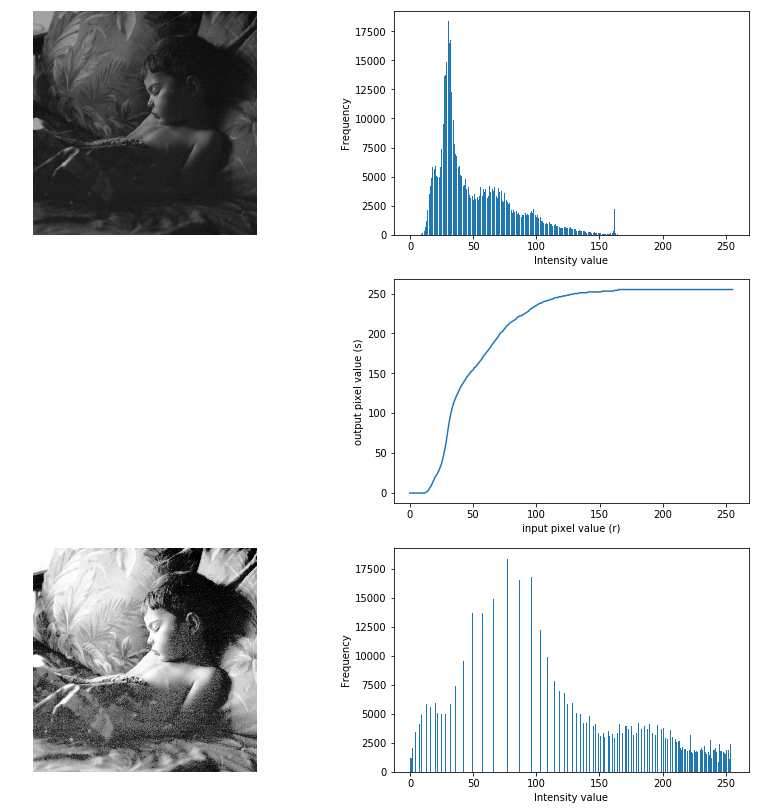

In [14]:
# compute the new histograms (after equalisation)
histeq_img1 = histogram(img1_eq, 256)
histeq_img2 = histogram(img2_eq, 256)

# show all images, histograms and transformation functions

plt.figure(figsize=(14,14)) 
plt.subplot(3,2,1)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(3,2,2)
plt.bar(range(256), hist_img1)
plt.xlabel('Intensity value')
plt.ylabel('Frequency')
plt.subplot(3,2,4)
plt.plot(range(256), img1_transf)
plt.xlabel('input pixel value (r)')
plt.ylabel('output pixel value (s)')

plt.subplot(3,2,5)
plt.imshow(img1_eq, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(3,2,6)
plt.bar(range(256), histeq_img1)
plt.xlabel('Intensity value')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

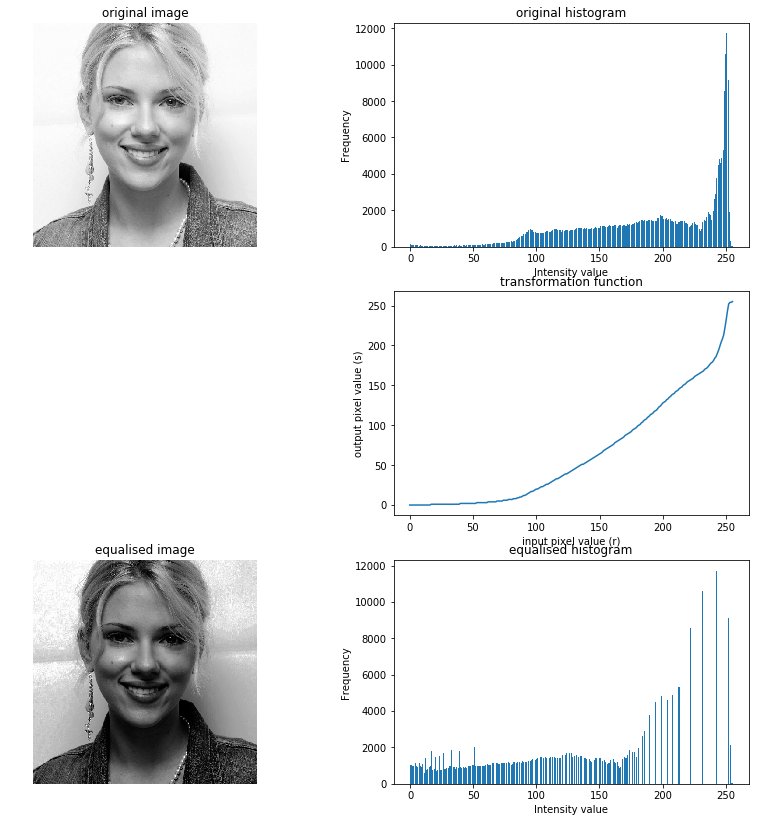

In [15]:
plt.figure(figsize=(14,14)) 

plt.subplot(3,2,1)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.title('original image')
plt.axis('off')
plt.subplot(3,2,2)
plt.bar(range(256), hist_img2)
plt.title('original histogram')
plt.xlabel('Intensity value')
plt.ylabel('Frequency')
plt.subplot(3,2,4)
plt.plot(range(256), img2_transf)
plt.title('transformation function')
plt.xlabel('input pixel value (r)')
plt.ylabel('output pixel value (s)')

plt.subplot(3,2,5)
plt.imshow(img2_eq, cmap="gray", vmin=0, vmax=255)
plt.title('equalised image')
plt.axis('off')
plt.subplot(3,2,6)
plt.bar(range(256), histeq_img2)
plt.title('equalised histogram')
plt.xlabel('Intensity value')
plt.ylabel('Frequency')


Note that, for some images, although the equalisation produced exactly what was expected - to better distribute the graylevels, the visual effect may not be pleasant. In this last case, the face of the woman became too dark, and the appearance of the wall behind her now shows new details that could not be easily spotted in the original image.

Therefore, the histogram equalisation must be used only when knowing its effects would produce the desired enhancement.